## Airline Sentiment -- Version2

In [1]:
%load_ext watermark
%watermark 

Last updated: 2022-04-16T08:20:18.725001-07:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.0.1

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [2]:
## We start by importing the packages we will use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime
import re

from nltk.corpus import stopwords

# Stemming
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# cleaning geographical data
#import geotext
import nltk

# vectorisor
from sklearn.feature_extraction.text import TfidfVectorizer

# models
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, roc_auc_score, roc_curve

# multiclass
from sklearn.multiclass import OneVsRestClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

## Import Local Functions

from functions import (preview_data,
                       get_missing_counts,
                       get_value_counts,
                       get_unique_column_count,
                       get_datetimes,
                       drop_null_values)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', None,'max.columns', None,'display.max_colwidth', 200)

In [3]:
## We Load our dataframe in df
tweets = pd.read_csv('./Airlines-NLP-Data/Tweets.csv')
tweets.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.349,NaN,0.000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.684,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [4]:
preview_data(tweets)

First Five Rows of Data: 



,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.349,NaN,0.000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.684,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.000,Bad Flight,0.703,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.000,Can't Tell,1.000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)



 Shape: 

(14640, 15)

 Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created              

In [5]:
#Number of sentiments in each category

tweets.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


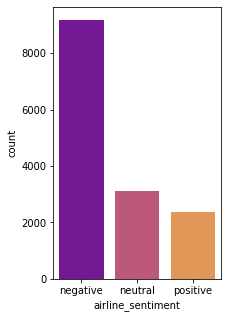

In [7]:
plt.figure(figsize=(3,5))
sns.countplot(tweets['airline_sentiment'], order =tweets.airline_sentiment.value_counts().index,palette= 'plasma')
plt.show()

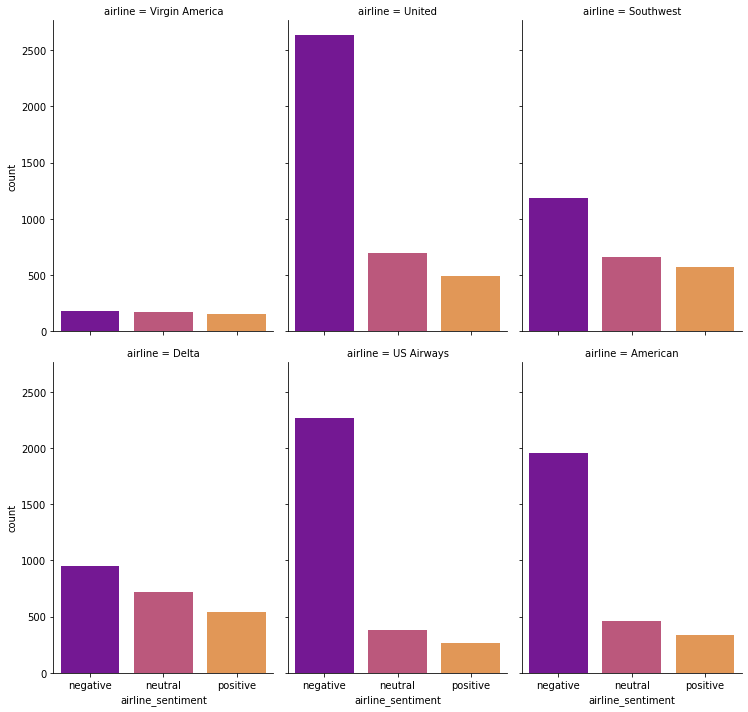

In [8]:
g = sns.FacetGrid(tweets, col="airline", col_wrap=3, height=5, aspect =0.7)
g = g.map(sns.countplot, "airline_sentiment",order =tweets.airline_sentiment.value_counts().index, palette='plasma')
plt.show()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from warnings import filterwarnings
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

In [11]:
twitter_sentiment = Pipeline([('CVec',CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer()),
                      ('norm', Normalizer()),
                    ('tSVD', TruncatedSVD(n_components=100)),
                     ('lgb', LGBMClassifier(n_jobs=-1))])

In [12]:
%%time
cv_pred = cross_validate(twitter_sentiment, 
                             tweets['text'], 
                             tweets['airline_sentiment'], 
                             cv=5,
                             scoring=('roc_auc_ovr'))

CPU times: total: 1min 16s
Wall time: 14.2 s


In [13]:
sorted(cv_pred.keys())

['fit_time', 'score_time', 'test_score']

In [ ]:
cv_pred['test_score']